In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

import matplotlib.pyplot as mp
import seaborn as sb

from mpl_toolkits.mplot3d import axes3d
from matplotlib import style

import warnings
warnings.filterwarnings('ignore')

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

from scipy.stats import entropy
import zstandard   #compresor
from tqdm import tqdm

from tqdm import tqdm

%matplotlib inline

In [2]:
review = pd.read_csv("review-001.csv", low_memory=False)

In [4]:
negocios = pd.read_csv("business.csv", low_memory=False)

In [5]:
check = pd.read_csv("checkin.csv", low_memory=False)

In [6]:
user = pd.read_csv("user-002.csv", low_memory=False)

In [7]:
tips = pd.read_csv("tip.csv", low_memory=False)

## PARTE 1

### P7:  Teniendo en cuenta las reviews que reciben los locales, devolver una del local que haya recibido más votos del tipo divertido en sus reviews.

In [8]:
unionReviewYNegocios = pd.merge(review, negocios, how='inner', on='business_id')

In [9]:
LocalesMasDivertidos=unionReviewYNegocios.groupby(['business_id','name']).agg({'funny':'sum'}).rename(columns={'funny':'Cant_De_Funny'})
LocalMasDivertido=LocalesMasDivertidos.nlargest(1,'Cant_De_Funny')
LocalMasDivertido

,,Cant_De_Funny
business_id,name,
VVH6k9-ycttH3TV_lk5WfQ,Willie Mae's Scotch House,1004.0


### P17: Queremos saber cuáles son los negocios más sexys, para esto vamos a ver cuáles son los 3 el negocios con más tips que contengan el texto “sexy”

Se cuenta como 1 tips, cuando en text aparezca al menos una sola vez la palabra Sexy o sexy, si aparece mas de una vez la palabra en el mismo text, no se considera en el conteo

In [10]:
palabrasSexys=tips[tips.text.str.contains('sexy', case = False, na = False)]

In [11]:
unionTipsSexys=pd.merge(negocios, palabrasSexys, how='inner', on='business_id')

In [12]:
agrupo=unionTipsSexys.groupby(['business_id','name']).agg({'text':'count'}).rename(columns={'text':'cantDePalabraSexy'})
negociosMasSexys=agrupo.nlargest(3,'cantDePalabraSexy')
negociosMasSexys

,,cantDePalabraSexy
business_id,name,
IxX6YczoeBpdt78AzDS4GQ,The Butcher And Barkeep,5
4xEJiEQERBvr2jAZQSeF2g,Mojo Tapas,4
X9e_btDPux6JGqqw8UF_Pg,Koizi Endless Hibachi & Sushi Eatery,4


### P18: Yelp tiene la teoría de que quienes hacen las reviews más útiles en la plataforma son aquellos usuarios con más antigüedad. Para probar está hipótesis para cada review consiga la suma total de sus votos (funny + cool + useful) y correlacionela con la antigüedad del usuario al momento de hacer la review.

In [13]:
review['fecha']=pd.to_datetime(review['date'])
review['anio']=review['fecha'].dt.year
review['mes']=review['fecha'].dt.month
review['dia']=review['fecha'].dt.day

In [14]:
#FCU = Funny Cool Useful
review['SumaFCU']=review['funny']+review['cool']+review['useful']

In [15]:
tabla=review.groupby('anio').agg({'SumaFCU':['count','sum','mean']})
tabla

SumaFCU                     
       count        sum      mean
anio                             
2017  820048  1422633.0  1.734817
2018  906362  1535272.0  1.693884
2019  907284  1499413.0  1.652639
2020  554557   989957.0  1.785131
2021  618189   965700.0  1.562144
2022   31665    39865.0  1.258961

### V2: Consiga exactamente esta visualización utilizando los datos:

In [19]:
dfV2=user[['compliment_cool','compliment_funny','compliment_hot','compliment_more','compliment_note','compliment_photos','compliment_plain','compliment_writer']]

dfV2.rename(columns={'compliment_hot':'Hot','compliment_more':'More','compliment_cool':'Cool','compliment_funny':'Funny','compliment_note':'Note','compliment_photos':'Photos','compliment_plain':'Plain','compliment_writer':'Writer'}, inplace=True)

(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5]),
 [Text(0, 0.5, 'Cool'),
  Text(0, 1.5, 'Funny'),
  Text(0, 2.5, 'Hot'),
  Text(0, 3.5, 'More'),
  Text(0, 4.5, 'Note'),
  Text(0, 5.5, 'Photos'),
  Text(0, 6.5, 'Plain'),
  Text(0, 7.5, 'Writer')])

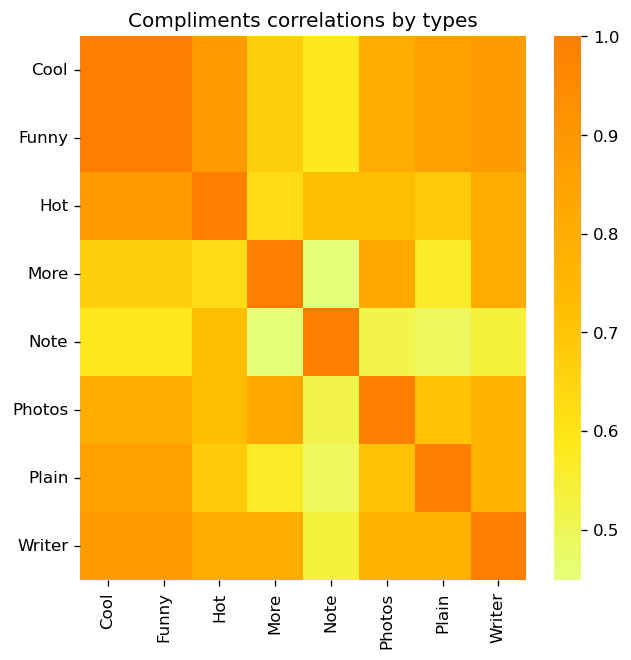

In [68]:
fig, ax = plt.subplots(figsize=(6,6), dpi =120) 

dataplot = sb.heatmap(dfV2.corr(), cmap="Wistia")

ax.set_title('Compliments correlations by types')

plt.xticks(rotation = 'vertical')
plt.yticks(rotation = 'horizontal')

### N6: Uno de los mayores problemas de las reviews es que los usuarios tienen distintas escalas en puntaje para las mismas experiencias, entonces las estrellas que suele dejar un usuario no son comparables con las otro. Para normalizar un poco más esto, Yelp quiere que el usuario primero escriba el texto y según qué tan positivo o negativo sea sugerirle la cantidad de estrellas a dejar. vaderSentiment y textblob de python son dos librerías para analizar sentimientos, ambas pueden darnos un score de que tan positivo o negativo es el sentimiento de un texto. Para los textos reviews, cuál de los dos scores de emoción mejor correlaciona con el puntaje que esa review deja?

In [22]:
dfN6=review[['user_id','business_id','stars','text']]
dfN6.head()

,user_id,business_id,stars,text
0,mh_-eMZ6K5RLWhZyISBhwA,XQfwVwDr-v0ZS3_CbbE5Xw,3.0,"If you decide to eat here, just be aware it is..."
1,bcjbaE6dDog4jkNY91ncLQ,e4Vwtrqf-wpJfwesgvdgxQ,4.0,Cute interior and owner (?) gave us tour of up...
2,RreNy--tOmXMl1en0wiBOg,cPepkJeRMtHapc_b2Oe_dw,4.0,I was really between 3 and 4 stars for this on...
3,Jha0USGDMefGFRLik_xFQg,bMratNjTG5ZFEA6hVyr-xQ,5.0,First time there and it was excellent!!! It fe...
4,4hBhtCSgoxkrFgHa4YAD-w,bbEXAEFr4RYHLlZ-HFssTA,5.0,"Great burgers,fries and salad! Burgers have a..."


### C5: Comprima todos los textos de las reviews obteniendo un ratio de compresión mejor que 2.

In [3]:
#COMPRIME UN ARCHIVO Y NOS DEVUELVE EL LARGO DEL ARCHIVO COMPRIMIDO
def comprimir(archivo):
    return len(zstandard.compress(archivo))

#DISTANCIA NORMALIZADA DE COMPRESION
def ncd(archivo1, archivo2):
    longitud1 = comprimir(archivo1)
    longitud2 = comprimir(archivo2)
    concat_len = len(zstandard.comprimir(archivo1 + archivo2))
    return (concat_len - min(archivo1, archivo2) / max(archivo1, archivo2))

In [4]:
#Es necesario que se pase una lista para mi funcion comprimir
textos = review['text'].tolist()

In [5]:
#prueba2=textos[:(len(textos)//100)]
#prueba2=textos
#prueba2 = textos[:5]

In [6]:
def comprimir(archivo):
    return len(zstandard.compress(archivo))

In [7]:
def concatenoTextos(text):

    concat = ''

    for texfile in text:
         concat += texfile
        
    return concat

In [8]:
def concatenoTextoscomprimido(text):

    concat = ''

    for texfile in text:
         concat += texfile
        
    return comprimir((concat).encode())

### ¿De cuanto es el ratio de compresión?

In [10]:
ratio = len(concatenoTextos(textos).encode())/ concatenoTextoscomprimido(textos)
ratio

2.72773035838292

### ¿Cuánto tarda en comprimir y descomprimir (por separado)? (use el magic %%timeit)

In [11]:
%%timeit
len(concatenoTextos(textos).encode())

25.4 s ± 723 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [12]:
%%timeit
concatenoTextoscomprimido(textos)

40.5 s ± 1.77 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


### ¿Cuánto ocupa cada carácter en promedio una vez comprimido?

In [13]:
rta = 8 / concatenoTextoscomprimido(textos)
rta

1.0826823067632475e-08

### Si tomamos la entropía base dos para los caracteres ¿cuánto da? ¿cuantos bytes por caracter son esos?

In [14]:
def listaDeCantidadDeCaracteres(lista):
    
    listaCantDeCaracteres = []
    
    for texfile in lista:
          listaCantDeCaracteres.append(len(texfile))
            
    return  listaCantDeCaracteres    

In [15]:
listaDeCantidadDeCaracteres(textos)

[513,
 534,
 1555,
 222,
 209,
 169,
 384,
 1369,
 393,
 101,
 621,
 248,
 413,
 217,
 256,
 153,
 315,
 1213,
 288,
 325,
 144,
 241,
 225,
 475,
 1057,
 296,
 107,
 93,
 207,
 261,
 179,
 1896,
 231,
 960,
 541,
 556,
 168,
 828,
 222,
 331,
 104,
 571,
 148,
 913,
 941,
 392,
 314,
 242,
 170,
 128,
 713,
 124,
 507,
 201,
 1355,
 556,
 717,
 508,
 644,
 765,
 217,
 193,
 369,
 1295,
 226,
 654,
 223,
 617,
 677,
 559,
 764,
 410,
 955,
 114,
 278,
 111,
 579,
 190,
 367,
 906,
 261,
 361,
 517,
 97,
 166,
 204,
 716,
 483,
 154,
 119,
 1336,
 474,
 676,
 2752,
 384,
 105,
 134,
 299,
 133,
 558,
 88,
 847,
 542,
 230,
 602,
 761,
 702,
 977,
 86,
 392,
 194,
 443,
 359,
 395,
 185,
 458,
 112,
 149,
 120,
 497,
 97,
 191,
 122,
 884,
 973,
 191,
 133,
 149,
 597,
 492,
 454,
 1571,
 909,
 647,
 501,
 254,
 154,
 231,
 155,
 490,
 1424,
 519,
 171,
 169,
 349,
 2915,
 1134,
 755,
 2473,
 1051,
 2275,
 570,
 320,
 1947,
 565,
 955,
 150,
 360,
 392,
 664,
 471,
 277,
 160,
 85,
 543,

In [17]:
entropy(listaDeCantidadDeCaracteres(textos), base= 2)

21.410361332593116

### C7: Para aquellos negocios que tengan más de 5 sucursales y su distribución probabilística de sucursales por ciudad.
Calcule la divergencia de Kullback Leibler entre todos los negocios:
    
¿Por qué dan casi todas infinito? Para corregirlo recalcule todo sumando 1*10^-10 en el denominador del logaritmo.

¿A qué negocios y en qué sentido corresponde la menor divergencia de Kullback Leibler? (recordar que la divergencia es dirigida)

¿Cuál es el negocio con mejor divergencia de Kullback-Leibler respecto de Burger King? ¿Y de McDonalds?

In [27]:
seleccionoCol= negocios.loc[:,['name','city','is_open']]

In [28]:
seleccionoCol['cantDeSuc']=seleccionoCol.groupby('name')['is_open'].transform(lambda x: x.sum())

In [29]:
#seleccionamos aquellos negocios con mas de 5 sucursales
sucursalesMayorA5 = seleccionoCol[seleccionoCol['cantDeSuc']>5]
sucursalesMayorA5

,name,city,is_open,cantDeSuc
1,The UPS Store,Affton,1,270
2,Target,Tucson,0,111
5,Sonic Drive-In,Ashland City,1,108
6,Famous Footwear,Brentwood,1,11
9,Sonic Drive-In,Nashville,1,108
...,...,...,...,...
150321,Starbucks,Indianapolis,1,607
150325,Wawa,Clifton Heights,1,294
150327,Dutch Bros Coffee,Boise,1,32
150341,Binh's Nails,Edmonton,1,10


In [30]:
unicosCity=sucursalesMayorA5['city'].unique()
sorted(unicosCity)

['ARDMORE',
 'Abington',
 'Abington Township',
 'Affton',
 'Algiers',
 'Alton',
 'Ambler',
 'Andalusia',
 'Antioch',
 'Apollo Beach',
 'Arabi',
 'Ardmore',
 'Arnold',
 'Ashland City',
 'Aston',
 'Atco',
 'Audubon',
 'Avon',
 'Avondale',
 'BOISE AP',
 'BRANDON',
 'Bala Cynwyd',
 'Ballwin',
 'Barrington',
 'Bayonet Point',
 'Beaumont',
 'Beech Grove',
 'Bel Ridge',
 'Belle Chase',
 'Belle Chasse',
 'Belle Meade',
 'Belleair Bluffs',
 'Bellefontaine',
 'Bellefontaine Neighbors',
 'Bellefonte',
 'Belleville',
 'Bellevue',
 'Bellmawr',
 'Bellville',
 'Bensalem',
 'Berkeley',
 'Berlin',
 'Berlin Township',
 'Berwyn',
 'Bethalto',
 'Beverly',
 'Black Jack',
 'Blackwood',
 'Blue Bell',
 'Boise',
 'Boise (Meridian)',
 'Boone',
 'Boothwyn',
 'Bordentown',
 'Boyertown',
 'Brandon',
 'Breckenridge Hills',
 'Brentwood',
 'Brentwood - Cool Springs',
 'Bridge City',
 'Bridgeport',
 'Bridgeton',
 'Bristol',
 'Brookhaven',
 'Brooklawn',
 'Broomall',
 'Brownsburg',
 'Bryn Mawr',
 'Buckingham',
 'Burling

In [31]:
sucursalesMayorA5['city']=sucursalesMayorA5['city'].apply(lambda x: 'Abington' if 'Abington Township' in x else x )
sucursalesMayorA5['city']=sucursalesMayorA5['city'].apply(lambda x: 'Ardmore' if 'ARDMORE' in x else x )
sucursalesMayorA5['city']=sucursalesMayorA5['city'].apply(lambda x: 'Belle Chase' if 'Belle Chasse' in x else x )
sucursalesMayorA5['city']=sucursalesMayorA5['city'].apply(lambda x: 'Belleair Bluffs' if 'Belleair Blf' in x else x )
sucursalesMayorA5['city']=sucursalesMayorA5['city'].apply(lambda x: 'Bellefontaine' if 'Bellefontaine Neighbors' in x else x )
sucursalesMayorA5['city']=sucursalesMayorA5['city'].apply(lambda x: 'Bellefontaine' if 'Bellefonte' in x else x )
sucursalesMayorA5['city']=sucursalesMayorA5['city'].apply(lambda x: 'Berlin' if 'Berlin Township' in x else x )
sucursalesMayorA5['city']=sucursalesMayorA5['city'].apply(lambda x: 'Blackwood' if 'Blackwood ' in x else x )
sucursalesMayorA5['city']=sucursalesMayorA5['city'].apply(lambda x: 'Boise' if 'Boise (Meridian)' in x else x )
sucursalesMayorA5['city']=sucursalesMayorA5['city'].apply(lambda x: 'Brentwood' if 'Brentwood - Cool Springs' in x else x )
sucursalesMayorA5['city']=sucursalesMayorA5['city'].apply(lambda x: 'Burlington' if 'Burlington Township' in x else x )
sucursalesMayorA5['city']=sucursalesMayorA5['city'].apply(lambda x: 'CLEARWATER' if 'CLEARWATER BEACH'in x else x )
sucursalesMayorA5['city']=sucursalesMayorA5['city'].apply(lambda x: 'Carneys Point' if "Carney's Point" in x else x )
sucursalesMayorA5['city']=sucursalesMayorA5['city'].apply(lambda x: 'Cherry Hill' if 'Cherry Hill Mall' in x else x )
sucursalesMayorA5['city']=sucursalesMayorA5['city'].apply(lambda x: 'Chester' if 'Chester Springs' in x else x )
sucursalesMayorA5['city']=sucursalesMayorA5['city'].apply(lambda x: 'ClearWater' if 'Clearwater' in x else x )
sucursalesMayorA5['city']=sucursalesMayorA5['city'].apply(lambda x: 'ClearWater' if 'Clearwater Beach' in x else x )
sucursalesMayorA5['city']=sucursalesMayorA5['city'].apply(lambda x: 'ClearWater' if 'Clearwater' in x else x )
sucursalesMayorA5['city']=sucursalesMayorA5['city'].apply(lambda x: 'Delran' if'Delran Twp' in x else x )
sucursalesMayorA5['city']=sucursalesMayorA5['city'].apply(lambda x: 'Deptford' if 'Deptford Township' in x else x )
sucursalesMayorA5['city']=sucursalesMayorA5['city'].apply(lambda x: 'Deptford' if 'Deptford Twp' in x else x )
sucursalesMayorA5['city']=sucursalesMayorA5['city'].apply(lambda x: 'Edgmont' if 'Edmonton' in x else x )
sucursalesMayorA5['city']=sucursalesMayorA5['city'].apply(lambda x: 'Ewing Township' if 'Ewing Twp' in x else x )
sucursalesMayorA5['city']=sucursalesMayorA5['city'].apply(lambda x: 'Fairview Heights' if 'Fairview Hts' in x else x )
sucursalesMayorA5['city']=sucursalesMayorA5['city'].apply(lambda x: 'Fairview Heights' if 'Fairview Hts.' in x else x )
sucursalesMayorA5['city']=sucursalesMayorA5['city'].apply(lambda x: 'Feasterville Trev' if 'Feasterville Trevose' in x else x )
sucursalesMayorA5['city']=sucursalesMayorA5['city'].apply(lambda x: 'Feasterville Trev' if 'Feasterville-Trevose' in x else x )
sucursalesMayorA5['city']=sucursalesMayorA5['city'].apply(lambda x: 'Feasterville Trev' if 'Feasterville-trevose' in x else x )

sucursalesMayorA5['city']=sucursalesMayorA5['city'].apply(lambda x: 'Havertown' if 'Havertown, PA' in x else x )
sucursalesMayorA5['city']=sucursalesMayorA5['city'].apply(lambda x: 'Indianapolis' if 'Indianpolis' in x else x )
#FALTA COMPLETAR
sucursalesMayorA5['city']=sucursalesMayorA5['city'].apply(lambda x: 'St.Petersburg' if 'St Petersburg' in x else x )
sucursalesMayorA5['city']=sucursalesMayorA5['city'].apply(lambda x: 'St.Petersburg' if 'St. Petersburg' in x else x )
sucursalesMayorA5['city']=sucursalesMayorA5['city'].apply(lambda x: 'St.Petersburg' if 'Saint Petersburg' in x else x )

In [34]:
sucursalesMayorA5['cantSucXCity']=sucursalesMayorA5.groupby(['name','city'])['is_open'].transform(lambda x: x.sum())
#Solo a modo de ver lo que me toma el transform
#sucursalesMayorA5[sucursalesMayorA5['name']=='Famous Footwear']

In [35]:
sucursalesMayorA5['promDeSucxCity']=sucursalesMayorA5['cantSucXCity'] / sucursalesMayorA5['cantDeSuc']
#sucursalesMayorA5
#sucursalesMayorA5[sucursalesMayorA5['name']=='Famous Footwear']

In [36]:
sucMayorA5 = sucursalesMayorA5.drop(columns=['is_open'])

In [37]:
sucMayorA5

,name,city,cantDeSuc,cantSucXCity,promDeSucxCity
1,The UPS Store,Affton,270,1,0.003704
2,Target,Tucson,111,6,0.054054
5,Sonic Drive-In,Ashland City,108,1,0.009259
6,Famous Footwear,Brentwood,11,1,0.090909
9,Sonic Drive-In,Nashville,108,12,0.111111
...,...,...,...,...,...
150321,Starbucks,Indianapolis,607,41,0.067545
150325,Wawa,Clifton Heights,294,1,0.003401
150327,Dutch Bros Coffee,Boise,32,9,0.281250
150341,Binh's Nails,Edgmont,10,9,0.900000


#### *Calcule la divergencia de Kullback Leibler entre todos los negocios:

In [39]:
paraKL=sucMayorA5.loc[:,['name','promDeSucxCity']]

## PARTE 2

### ARCHIVO 1: Disney Movies

In [40]:
disney = pd.read_csv("disney_movies.csv", low_memory=False)

In [41]:
disney['genre'] = disney['genre'].map({'Musical':'Musicales',
                                      'Adventure':'Adventuras',
                                      'Drama': 'Dramas',
                                      'Comedy': 'Comedias',
                                      'Action': 'Accion',
                                       'Horror': 'Terror',
                                      'Romantic Comedy':'Comedias',
                                      'Thriller/Suspense':'Triller/Suspenso',
                                      'Western':'Westerns',
                                      'Black Comedy':'Comedias',
                                      'Documentary':'Documentales',
                                      'Concert/Performance':'Musicales'},
                                     na_action=None)

In [42]:
disney['fecha'] = pd.to_datetime(disney['release_date'])
disney['anio'] = disney['fecha'].dt.year

In [43]:
agrupoDisney = disney.loc[:,['genre','anio','inflation_adjusted_gross']]

In [44]:
tablaDisney = agrupoDisney.groupby(['anio','genre']).mean()

In [45]:
tablaDisney = tablaDisney.unstack(fill_value=0)

In [46]:
tablaDisney.columns = tablaDisney.columns.droplevel(0)

### Visualización de los géneros de las peliculas en el transcurso de todos los años

En esta visualización sólo se puede apreciar que entre la década 40 y 50, predominaban los musicales.
También se puede ver peliculas relacionadas a musicales, aventuras, dramas y comedias entre 40 a 70, mostrando subidas y bajadas de estos géneros.

Por otro lado, en esta visualización no podemos ver bien que pasa con las peliculas despues de 1980, por lo que se analizara en los proximos gráficos

<Figure size 432x288 with 0 Axes>

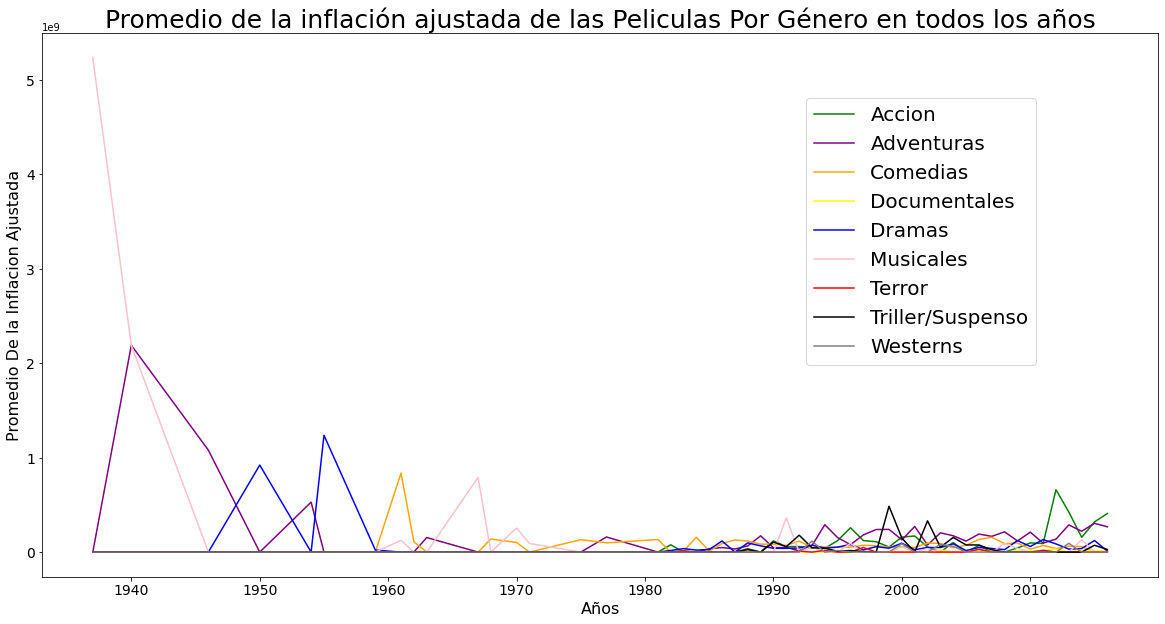

In [47]:
plt.figure()

ax=tablaDisney.plot(kind='line',figsize=(20,10),fontsize=14, 
              color=['green', 'purple', 'orange', 'yellow', 'blue','pink','red','black','gray']);

plt.title('Promedio de la inflación ajustada de las Peliculas Por Género en todos los años', color='black',fontsize=25);

ax.set_xlabel('Años',fontsize=16);
ax.set_ylabel('Promedio De la Inflacion Ajustada',fontsize=16);

plt.legend(loc='upper right', bbox_to_anchor=(0.9, 0.9), fontsize=20)

### ¿Qué pasa con las peliculas despúes de 1980?

Se puede ver que pese q a pesar del aumento de la inflación, la cantidad de peliculas ha ido creciendo, con leves picos 
de baja pero muestra un crecimiento a pesar de ello

In [48]:
disneyDesde1980 = agrupoDisney.loc[agrupoDisney['anio'] >= 1980]

In [49]:
disneyDesde1980.drop(labels=24, axis=0, inplace=True)
disneyDesde1980.drop(labels=25, axis=0, inplace=True)
disneyDesde1980.drop(labels=26, axis=0, inplace=True)

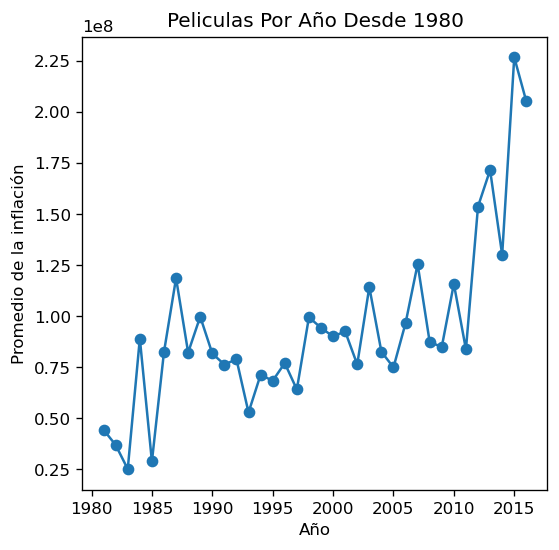

In [50]:
fig, ax = plt.subplots(figsize=(5,5), dpi =120) 

promXAnio= disneyDesde1980.groupby('anio')['inflation_adjusted_gross'].mean()
promXAnio.plot.line(title = "Peliculas Por Año Desde 1980", marker = 'o')

ax.set_ylabel('Promedio de la inflación',fontsize=10);
ax.set_xlabel('Año',fontsize=10);
plt.show()

### ¿Cuáles fuerón los géneros que tuvierón mayor crecimiento a partir de 1980?

Las peliculas de Adventuras fuerón las que más crecieron, siguiendole con las de acción.

Text(0, 0.5, 'Géneros')

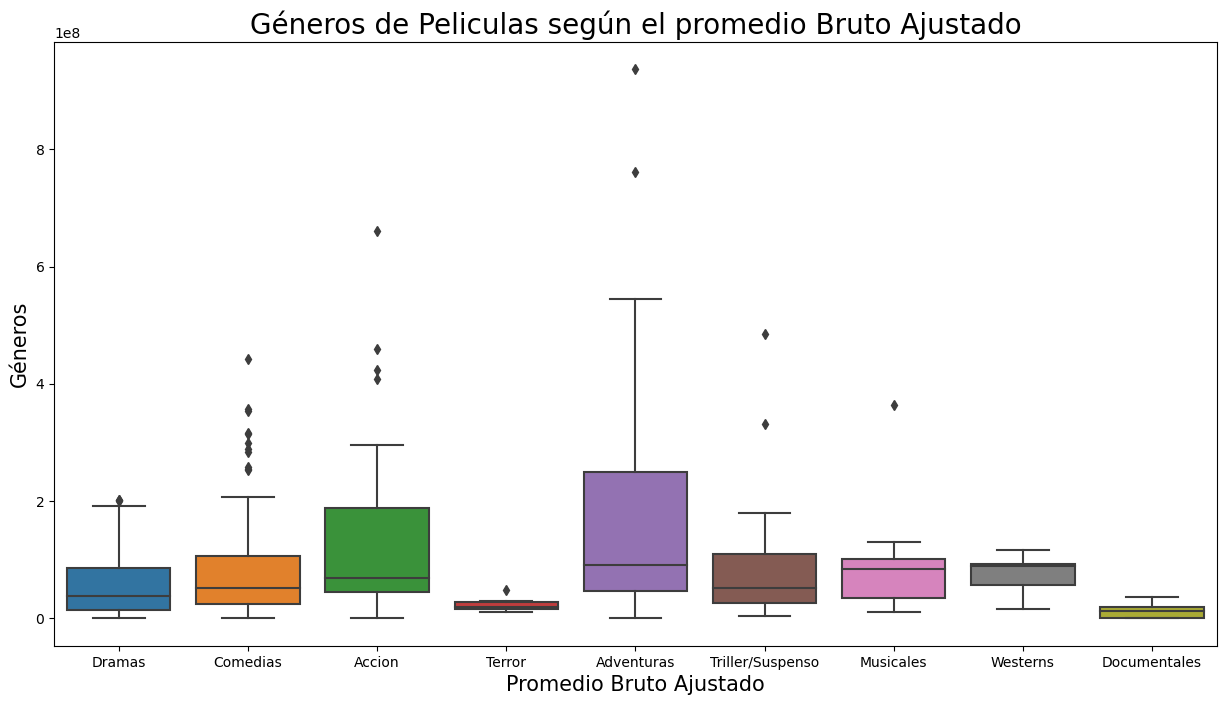

In [51]:
fig, ax = plt.subplots(figsize=(15,8), dpi=100)

ax = sns.boxplot(x='genre', y='inflation_adjusted_gross', data=disneyDesde1980)

ax.set_title('Géneros de Peliculas según el promedio Bruto Ajustado', fontsize=20);
plt.xlabel('Promedio Bruto Ajustado',  fontsize=15)
plt.ylabel('Géneros',  fontsize=15)

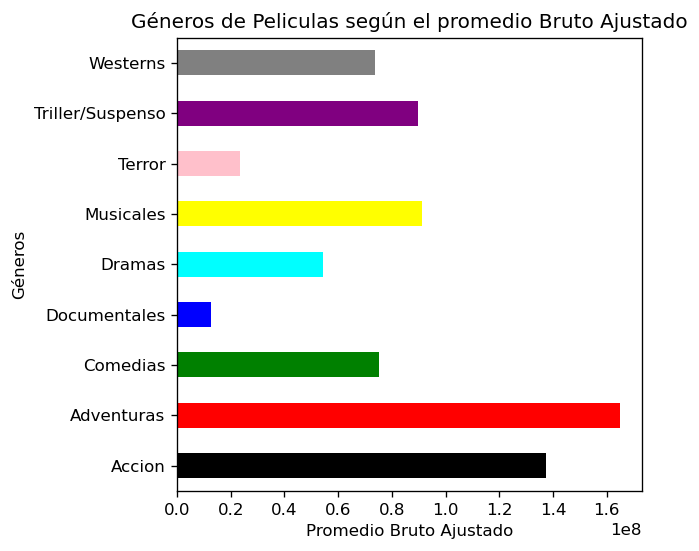

In [52]:
fig, ax = plt.subplots(figsize=(5,5), dpi =120) 

gruposGeneros=disneyDesde1980.groupby('genre')['inflation_adjusted_gross'].mean()
gruposGeneros.plot.barh(x = gruposGeneros.index.values, y = gruposGeneros.values,
                        color=['black', 'red', 'green', 'blue', 'cyan','yellow','pink','purple','gray'],
                title = 'Géneros de Peliculas según el promedio Bruto Ajustado')

plt.xlabel('Promedio Bruto Ajustado')
plt.ylabel('Géneros')
plt.show()

### ARCHIVO 2: Amazon Seller - Order Status Prediction

In [53]:
archivoOrders = pd.read_excel('orders_data.xlsx')

archivoOrders.to_csv ('orders_data.csv', 
                  index = None,
                  header=True)

In [54]:
orders = pd.read_csv('orders_data.csv', low_memory=False)

In [55]:
orders['fecha'] = pd.to_datetime(orders['order_date'])
orders['anio'] = orders['fecha'].dt.year
orders['mes'] = orders['fecha'].dt.month

orders['Anio-Mes'] = orders['fecha'].apply(lambda x: x.strftime('%Y-%m'))

In [56]:
orders.order_status.unique()

array(['Delivered to buyer', 'Returned to seller'], dtype=object)

In [57]:
orders['order_status'] = orders['order_status'].astype('category')

### ¿Cúales són la cantidad de productos entregados y devueltos según año y mes?

Se observa que en el Año/Mes 2021/12 huboo una gran entrega de productos.

In [58]:
groupedOrders = orders.loc[:,['Anio-Mes','order_status','quantity']].groupby(['Anio-Mes','order_status']).agg('count')
groupedOrders.reset_index(inplace=True)
groupedOrders

,Anio-Mes,order_status,quantity
0,2021-06,Delivered to buyer,7
1,2021-06,Returned to seller,1
2,2021-07,Delivered to buyer,7
3,2021-07,Returned to seller,0
4,2021-08,Delivered to buyer,12
5,2021-08,Returned to seller,1
6,2021-09,Delivered to buyer,18
7,2021-09,Returned to seller,0
8,2021-10,Delivered to buyer,24
9,2021-10,Returned to seller,3


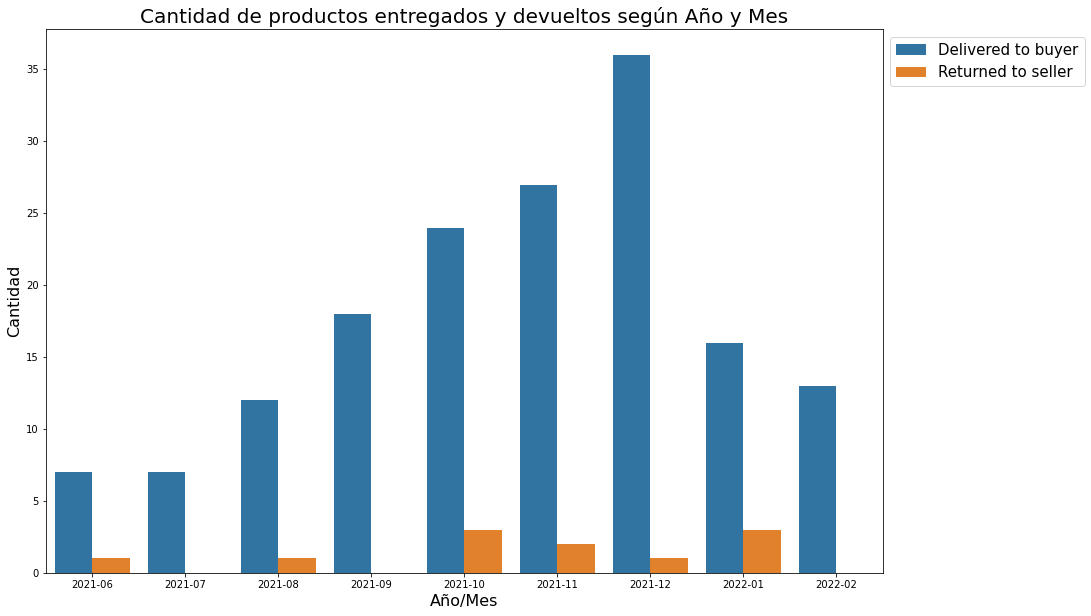

In [59]:
plt.figure(figsize=(15,10))

figure = sns.barplot(y= groupedOrders['quantity'], x=groupedOrders['Anio-Mes'], hue=groupedOrders['order_status'])

plt.title("Cantidad de productos entregados y devueltos según Año y Mes", fontsize=20)
plt.xlabel("Año/Mes", fontsize=16) 
plt.ylabel("Cantidad", fontsize=16)
plt.legend(loc='upper left', bbox_to_anchor=(1.0,1.0), fontsize=15)

### ¿Cual fue el minimo y maximo de las los productos entregados y devueltos?

La pifie mal, pq si fue devuelto, era claro que no hay pago (item_total). 

In [60]:
orders['item_total'].fillna('0', inplace= True)

In [61]:
for label in ['item_total']:
        orders[label] = orders[label].str.replace('₹', '')
        orders[label] = orders[label].str.replace(',', '')
        orders[label] = orders[label].astype(np.float64)

In [62]:
modificoStatus = orders.rename(columns = {0:'Delivered to buyer', 1:'Returned to seller'})

In [63]:
tablaOrders = modificoStatus.groupby('order_status').agg({'item_total': ['max', 'min', 'mean', 'count']})
tablaOrders.columns = ['max', 'min', 'mean', 'count']
tablaOrders.reset_index()
tablaOrders

,max,min,mean,count
order_status,,,,
Delivered to buyer,3897.0,0.0,557.35625,160
Returned to seller,0.0,0.0,0.00000,11


Text(0.5, 0, 'order status')

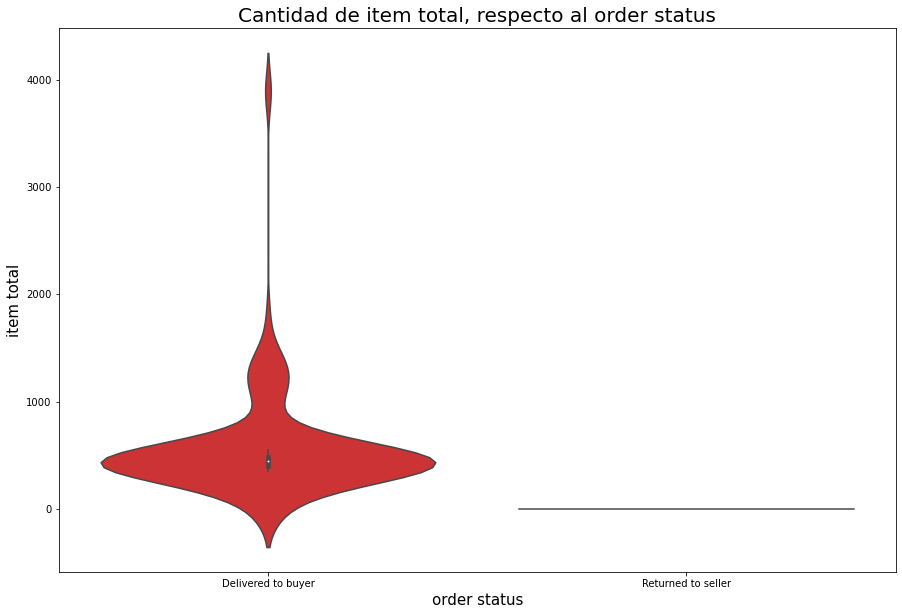

In [64]:
plt.figure(figsize=(15,10))

plot = sns.violinplot(x='order_status', y='item_total', data=orders, palette = 'Set1')

plot.set_title("Cantidad de item total, respecto al order status", fontsize=20)
plot.set_ylabel("item total", fontsize=15)
plot.set_xlabel("order status", fontsize=15)